In [109]:
import torch
import torch.nn as nn

import matplotlib.pyplot as plt
import numpy as np

In [110]:
class KANLayer(nn.Module):
    def __init__(self, in_dim, out_dim, num_intervals, spline_order):
        super(KANLayer, self).__init__()

        self.in_dim = in_dim
        self.out_dim = out_dim

        self.num_intervals = num_intervals
        self.spline_order = spline_order
        
        initial_domain = [-1, 1]
        num_control_points = num_intervals + spline_order
        variance = 0.1

        # Parameters for in_dim * out_dim activation functions
        # Initialize control points for all activations
        self.control_points = nn.Parameter(torch.as_tensor(np.random.normal(0, variance, (in_dim, out_dim, num_control_points))), requires_grad=True)

        # Initialize grid per activation function
        grid = torch.linspace(initial_domain[0], initial_domain[1], num_intervals + 1)
        step_size = (initial_domain[1] - initial_domain[0]) / num_intervals

        pre_padding = torch.linspace(initial_domain[0] - spline_order * step_size, initial_domain[0] - step_size, spline_order)
        post_padding = torch.linspace(initial_domain[1] + step_size, initial_domain[1] + spline_order * step_size, spline_order)
        extended_grid = torch.cat((pre_padding, grid, post_padding))

        self.grids = extended_grid.repeat(in_dim * out_dim, 1).reshape(in_dim, out_dim, -1)

        # Residual function silu
        self.silu = nn.SiLU()

        # Initialize weights for the scaling factor with Xavier initialization
        xavier_weights = np.random.normal(0, np.sqrt(2 / out_dim), (in_dim, out_dim))
        self.scaling_factors = nn.Parameter(torch.as_tensor(xavier_weights), requires_grad=True)
        
    def batched_cox_de_boor(self, i, degree, x):
        expanded_x = x.unsqueeze(-1)

        if degree == 0:
            return (self.grids[:, :, i] <= expanded_x) * (expanded_x < self.grids[:, :, i + 1])
        
        left_side = (expanded_x - self.grids[:, :, i]) / (self.grids[:, :, i + degree] - self.grids[:, :, i]) * self.batched_cox_de_boor(i, degree - 1, x)
        right_side = (self.grids[:, :, i + degree + 1] - expanded_x) / (self.grids[:, :, i + degree + 1] - self.grids[:, :, i + 1]) * self.batched_cox_de_boor(i + 1, degree - 1, x)

        return left_side + right_side
    
    def compute_spline(self, x):
        result = 0.0
        for i in range(self.num_intervals + self.spline_order):
            result += self.control_points[:, :, i] * self.batched_cox_de_boor(i, self.spline_order, x)

        return result
    
    def forward(self, x):
        # Compute activations
        result = self.compute_spline(x)

        # Add residual connection and scaling
        res_x = self.silu(x)
        result = self.scaling_factors * (res_x.unsqueeze(-1) + result)

        # Sum results into neurons for next layer
        result = result.reshape(x.shape[0], self.in_dim, self.out_dim)
        result = torch.sum(result, dim=1)

        return result

Epoch 0, loss: 0.2500958472436988


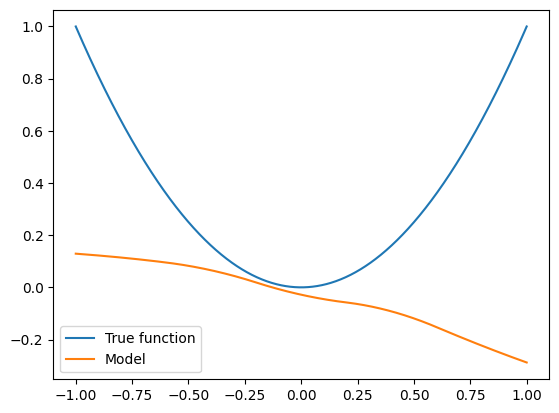

In [111]:
# 1D example
model = KANLayer(1, 1, 5, 2)

opt = torch.optim.Adam(model.parameters(), lr=0.01)

def f(x):
    return x**2

data = torch.linspace(-1, 1, 1000)
labels = f(data)

for i in range(1):
    opt.zero_grad()

    out = model(data)[:, 0]
    loss = (out - labels)**2
    loss = loss.mean()
    loss.backward()
    opt.step()

    if i % 100 == 0:
        print(f"Epoch {i}, loss: {loss.item()}")

plt.plot(data, labels, label="True function")
plt.plot(data, out.detach().numpy(), label="Model")

plt.legend()
plt.show()

In [112]:
new_data = torch.linspace(-0.5, 0.5, 128).unsqueeze(-1)
new_labels = f(new_data)

# Resample
new_num_intervals = 10

# Get ranges of activations
min_acts = torch.min(new_data, dim=0).values
max_acts = torch.max(new_data, dim=0).values

# Update grid
domains = torch.stack([min_acts, max_acts], dim=1).unsqueeze(1)
print(domains)

step_sizes = (domains[:, :, 1] - domains[:, :, 0]) / new_num_intervals
extended_grid = (domains[:, :, 0] - 2 * step_sizes).unsqueeze(-1) + torch.arange(0, new_num_intervals + 2 * 2 + 1).reshape(1, 1, -1) * step_sizes[:, None]

print(extended_grid)
print(model.grids.shape, extended_grid.shape)

tensor([[[-0.5000,  0.5000]]])
tensor([[[-0.7000, -0.6000, -0.5000, -0.4000, -0.3000, -0.2000, -0.1000,
           0.0000,  0.1000,  0.2000,  0.3000,  0.4000,  0.5000,  0.6000,
           0.7000]]])
torch.Size([1, 1, 10]) torch.Size([1, 1, 15])


torch.Size([1, 128, 12]) torch.Size([128, 1, 1])
torch.Size([1, 1, 12]) torch.Size([1, 1, 7])
Parameter containing:
tensor([[[-0.1004, -0.0615, -0.0352,  0.0971, -0.0323,  0.0405, -0.0061]]],
       dtype=torch.float64, requires_grad=True) tensor([[[-0.0451, -0.0319, -0.0121,  0.0144,  0.0475,  0.0642,  0.0646,
           0.0486,  0.0162, -0.0035, -0.0105, -0.0050]]],
       grad_fn=<UnsqueezeBackward0>)
torch.Size([1, 1, 12])
torch.Size([128])


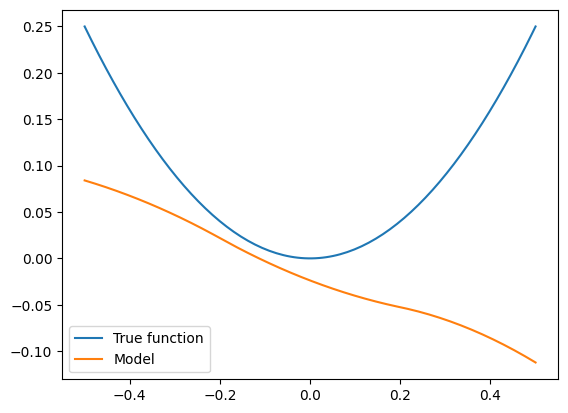

In [113]:
# Get old activations
old_out = model.compute_spline(new_data)

# Update control points with least squares
new_num_control_points = new_num_intervals + 2

model.grids.data = extended_grid
model.num_intervals = new_num_intervals

cdbs = []
for i in range(new_num_intervals + 2):
    cdbs.append(model.batched_cox_de_boor(i, 2, new_data))

cdbs = torch.cat(cdbs, dim=1).to(torch.float32).moveaxis(2, 0)
print(cdbs.shape, old_out.shape)

old_out = old_out.to(torch.float32)
new_control_points = torch.linalg.lstsq(cdbs[0], old_out[:, 0]).solution.T[None]

print(new_control_points.shape, model.control_points.shape)
print(model.control_points, new_control_points)

model.control_points.data = new_control_points
print(model.control_points.shape)
out = model(new_data)[:, 0]

print(out.shape)

plt.plot(new_data, new_labels, label="True function")
plt.plot(new_data, out.detach().numpy(), label="Model")

plt.legend()    
plt.show()

Epoch 0, loss: 0.46616633253719586


Epoch 100, loss: 0.0014613892544541093
Epoch 200, loss: 7.9040078576096e-05
Epoch 300, loss: 1.6669829352893032e-05
Epoch 400, loss: 4.391904530221888e-06
Epoch 500, loss: 1.0315080522638925e-06
Epoch 600, loss: 2.4255670256177456e-07
Epoch 700, loss: 8.924099934732509e-08
Epoch 800, loss: 6.503885384768183e-08
Epoch 900, loss: 6.197624384226485e-08


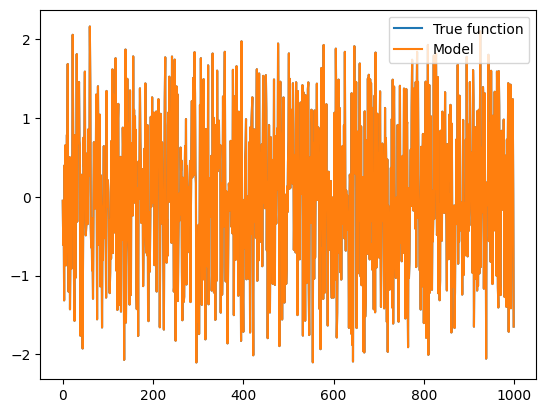

In [114]:
# 2D example
model = KANLayer(2, 1, 5, 2)

opt = torch.optim.Adam(model.parameters(), lr=0.01)

def f(x, y):
    return x + 1.2*y

data = torch.rand(1000, 2) * 2 - 1
labels = f(data[:, 0], data[:, 1])

for i in range(1000):
    opt.zero_grad()

    out = model(data)[:, 0]
    loss = (out - labels)**2
    loss = loss.mean()
    loss.backward()
    opt.step()

    if i % 100 == 0:
        print(f"Epoch {i}, loss: {loss.item()}")

plt.plot(labels, label="True function")
plt.plot(out.detach().numpy(), label="Model")

plt.legend()
plt.show()

In [115]:
new_data = torch.rand(100, 2) * 2 - 1
new_labels = f(new_data[:, 0], new_data[:, 1])

# Resample
new_num_intervals = 5

# Get ranges of activations
min_acts = torch.min(new_data, dim=0).values
max_acts = torch.max(new_data, dim=0).values

# Update grid
domains = torch.stack([min_acts, max_acts], dim=1).unsqueeze(1)
print(domains)

step_sizes = (domains[:, :, 1] - domains[:, :, 0]) / new_num_intervals
extended_grid = (domains[:, :, 0] - 2 * step_sizes).unsqueeze(-1) + torch.arange(0, new_num_intervals + 2 * 2 + 1).reshape(1, 1, -1) * step_sizes[:, None]

print(extended_grid)
print(model.grids.shape, extended_grid.shape)
print(model.grids)

tensor([[[-0.9910,  0.9823]],

        [[-0.9792,  0.8576]]])
tensor([[[-1.7803, -1.3857, -0.9910, -0.5963, -0.2017,  0.1930,  0.5876,
           0.9823,  1.3769,  1.7716]],

        [[-1.7139, -1.3465, -0.9792, -0.6118, -0.2445,  0.1229,  0.4902,
           0.8576,  1.2249,  1.5922]]])
torch.Size([2, 1, 10]) torch.Size([2, 1, 10])
tensor([[[-1.8000, -1.4000, -1.0000, -0.6000, -0.2000,  0.2000,  0.6000,
           1.0000,  1.4000,  1.8000]],

        [[-1.8000, -1.4000, -1.0000, -0.6000, -0.2000,  0.2000,  0.6000,
           1.0000,  1.4000,  1.8000]]])


In [116]:
# Get old activations
old_out = model.compute_spline(new_data)

# Update control points with least squares
new_num_control_points = new_num_intervals + 2

model.grids.data = extended_grid
model.num_intervals = new_num_intervals

cdbs = []
for i in range(new_num_intervals + 2):
    cdbs.append(model.batched_cox_de_boor(i, 2, new_data))

cdbs = torch.stack(cdbs).to(torch.float32)
print(cdbs.shape, old_out.shape)

old_out = old_out.to(torch.float32)
new_control_points = torch.linalg.lstsq(cdbs[0], old_out[:, 0]).solution.T[None]

print(new_control_points.shape, model.control_points.shape)
print(model.control_points, new_control_points)

model.control_points.data = new_control_points
print(model.control_points.shape)
out = model(new_data)[:, 0]

print(out.shape)

plt.plot(new_data, new_labels, label="True function")
plt.plot(new_data, out.detach().numpy(), label="Model")

plt.legend()    
plt.show()

torch.Size([7, 100, 2, 1]) torch.Size([100, 2, 1])


RuntimeError: torch.linalg.lstsq: input.size(-2) should match other.size(-1)